In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r ./yolov5/requirements.txt  # install

!pip install -U albumentations #using image augmentation feature in yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 10866, done.
remote: Total 10866 (delta 0), reused 0 (delta 0), pack-reused 10866
Receiving objects: 100% (10866/10866), 11.01 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (7503/7503), done.


In [3]:
import random
import numpy as np
import pandas as pd
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import os
import ast
import shutil

In [4]:
train = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv", index_col="image_id")
train.head(10)

,video_id,sequence,video_frame,sequence_frame,annotations
image_id,,,,,
0-0,0,40258,0,0,[]
0-1,0,40258,1,1,[]
0-2,0,40258,2,2,[]
0-3,0,40258,3,3,[]
0-4,0,40258,4,4,[]
0-5,0,40258,5,5,[]
0-6,0,40258,6,6,[]
0-7,0,40258,7,7,[]
0-8,0,40258,8,8,[]


(720, 1280, 3)


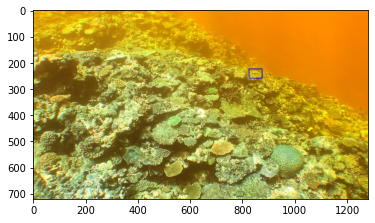

In [5]:
img = cv2.imread("../input/tensorflow-great-barrier-reef/train_images/video_0/978.jpg")
# from cv2 import cv2_imshow

start_pt = (825, 224)
end_pt = (875, 259)
color = (0, 0, 255)
thickness = 2
image = cv2.rectangle(img, start_pt, end_pt, color, thickness)
plt.imshow(image)
print(image.shape)

In [6]:
!mkdir -p ./datasets/coral/labels
!mkdir -p ./datasets/coral/images

path_to_txt_folder = "./datasets/coral/labels"
final_path_to_images = "./datasets/coral/images"

def txt_data(path):
    for folder in os.listdir(path):
        path_to_folder = os.path.join(path, folder)
        _, video_id = folder.split("_")

        for image in os.listdir(path_to_folder):
            path_to_image = os.path.join(path_to_folder, image)

            image_id, img_ext = image.split(".")
            image_match = video_id + "-" + image_id

            img_temp = cv2.imread(path_to_image)
            height, width, channels = img_temp.shape

            image_data = train.loc[image_match]
            annotation_list = ast.literal_eval(image_data.annotations)

            if bool(annotation_list) == True:
                path_to_file = os.path.join(path_to_txt_folder, image_match + ".txt")
                file_ = open(path_to_file, "w")
                for i in annotation_list:
                    x_min = i['x']
                    y_min = i['y']
                    box_width = i['width']
                    box_height = i['height']
                    class_label=str(0)
                    x_min = str(round((x_min+(box_width/2))/width, 10))
                    y_min = str(round((y_min+(box_height/2))/height, 10))
                    box_width = str(round(box_width/width, 10))
                    box_height = str(round(box_height/height, 10))
                    file_.write(class_label+" "+x_min+" "+y_min+" "+box_width+" "+box_height)
                file_.close()
    
                image_new_name = os.path.join(final_path_to_images, image_match + "." + img_ext)
#             new_path_to_image = os.path.join(final_path_to_images, image_new_name)
                shutil.copyfile(path_to_image, image_new_name)

txt_data("../input/tensorflow-great-barrier-reef/train_images")

(720, 1280, 3)


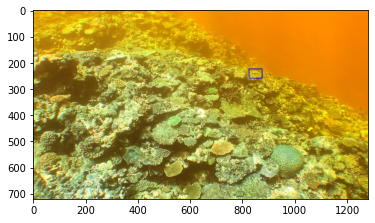

In [7]:
img = cv2.imread("./datasets/coral/images/0-978.jpg")
# from google.colab.patches import cv2_imshow

start_pt = (825, 224)
end_pt = (875, 259)
color = (0, 0, 255)
thickness = 2
image = cv2.rectangle(img, start_pt, end_pt, color, thickness)
plt.imshow(image)
print(image.shape)

In [8]:
shutil.copyfile("../input/coral-yaml/coral.yaml", "./yolov5/data/coral.yaml")
shutil.copyfile("../input/coral-yaml/hyp.yaml", "./yolov5/data/hyps/hyp.yaml")

'./yolov5/data/hyps/hyp.yaml'

In [9]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

!pip install wandb
!wandb login $secret_value_0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
## Train YOLOv5m on coral_dataset for 3 epochs
!python ./yolov5/train.py --img 1280 --rect --batch 4 --epochs 50 --data ./yolov5/data/coral.yaml --hyp ./yolov5/data/hyps/hyp.yaml --weights yolov5s.pt

wandb: Currently logged in as: ravishkumbhare (use `wandb login --relogin` to force relogin)
train: weights=yolov5s.pt, cfg=, data=./yolov5/data/coral.yaml, hyp=./yolov5/data/hyps/hyp.yaml, epochs=50, batch_size=4, imgsz=1280, rect=True, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-253-ga45e472 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=

In [18]:
shutil.make_archive("best_logical_oath_36_yolov5s", "zip", "./yolov5/runs/train/exp/weights")

'/kaggle/working/best_logical_oath_36_yolov5s.zip'

In [ ]:
import torch
ckpt_path = "./yolov5/runs/train/exp/weights/best.pt"

model = torch.hub.load('./yolov5', 'custom',
                           path=ckpt_path,
                           source='local',
                       force_reload=True)

model.conf = 0.20
model.iou = 0.45

results = model("./datasets/coral/images/0-4600.jpg")
results.print()
results.pandas().xyxy[0]

In [ ]:
rand_set = random.choices(os.listdir("./datasets/coral/labels"), k=10)
for i in rand_set:
    image, _ = i.split(".")
    file_name = os.path.join("./datasets/coral/images", image + ".jpg")
    results = model(file_name)
    print(file_name)
    results.print()
    results.pandas().xyxy[0]

In [ ]:
import greatbarrierreef

env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()